In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

#Dimensions of RR tape
REAL_HEIGHT = 5 #cm
REAL_WIDTH = 13 #cm

#RR tape masks
hsvLow = np.array([40, 40, 40])
hsvHigh = np.array([80, 255, 255])

#Limelight constants
PIXELS_WIDE = 320 #pixels
PIXELS_HIGH = 240 #pixels
FOV_Y = 49.7 #degrees
FOV_X = 59.6 #degrees
FOCAL_LENGTH = (PIXELS_HIGH / 2) / np.tan(math.pi / 180 * FOV_Y / 2)

#Other parameters
TARGET_HEIGHT = 263 #cm (measured from the top of the target to the ground)
CAMERA_HEIGHT = 61 #cm
CAMERA_ANGLE = 32 # degrees

Contour functions

In [48]:
#returns the contour of one of the detected RR tapes
def getGoalContour(image):
  #Mask filtering
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv, hsvLow, hsvHigh)
  contours, hiearchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #If no contours found, return None
  if(len(contours) > 0):

    #sorting an array of all x positions of contours
    contour_xcoords = []
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        contour_xcoords.append(x)
    contour_xcoords = np.sort(contour_xcoords)
    median_x = contour_xcoords[int(len(contours) / 2)]

    #finding the contour with the median x position
    target_contour = None
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        if(x == median_x):
          target_contour = contour
          break

    plt.imshow(cv2.drawContours(cv2.cvtColor(cv2.inRange(cv2.cvtColor(img_test, cv2.COLOR_BGR2HSV), hsvLow, hsvHigh), cv2.COLOR_BGR2RGB), [target_contour], -1, (255, 140, 191), 3), cmap='gray')
    plt.show()

    return target_contour
  return None



```
# This is formatted as code
```

Distance & turn angle things

In [49]:
#returns the horizontal distance (cm) from the RR tape to the camera
def getDistance(contour):
  x, y, width, height = cv2.boundingRect(contour)
  
  #normalizing the top y position of the goal contour to be from [1,-1]
  norm_Y = - (y - (PIXELS_HIGH / 2)) / (PIXELS_HIGH / 2)

  #finding the vertical angle (pitch) between the camera and the goal contour 
  pitch = 180 * np.arctan(norm_Y * np.tan(FOV_Y / 2 * math.pi / 180)) / math.pi # degrees
  
  #using trig to determine distance
  distance = (TARGET_HEIGHT - CAMERA_HEIGHT) / np.tan(math.pi * (CAMERA_ANGLE + pitch) / 180)

  return distance
  
#returns angle (deg) of the RR tape relative to the camera
def getAngle(contour):
  x, y, width, height = cv2.boundingRect(contour)

  #normalizing the left x position of the goal contour to be from [1,-1]
  norm_X = (x - (PIXELS_WIDE / 2)) / (PIXELS_WIDE / 2)

  #finding the horizontal angle between the camera and left edge of the goal contour
  angle = 180 * np.arctan(norm_X * np.tan(FOV_X / 2 * math.pi / 180)) / math.pi #degrees
  return angle

Launch Speed calculation

In [50]:
#converts the launch speed of the ball needed in m / s to motor power of the shooter
def launchSpeed2MotorPower(speed, K = 1e-1):
  return K * speed

#distance buffer is the amount of distance added to minimize error and to allow the ball to go to the middle of the target, not the front
# parameter units are degrees and cm
def getMotorPower(distance, angle = 65, height = TARGET_HEIGHT, distance_buffer = 10):
  g = 9.81
  d = (distance + distance_buffer) / 100
  theta = angle * math.pi / 180
  h = height / 100
  return launchSpeed2MotorPower(((d * np.sqrt(g)) / (np.cos(theta) * np.sqrt(2 * (d * np.tan(theta) - h)))))

Testing Cell

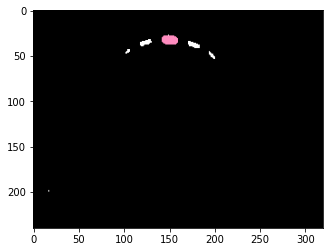

Calculated distance: 162.6774769258773
Real distance: 150.0
Calculated power: 0.861595353923444
Real power: 0.9196775160405102


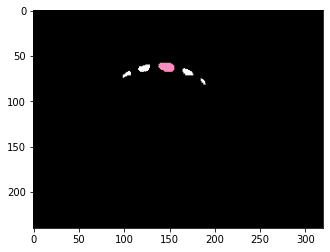

Calculated distance: 201.73404728617854
Real distance: 180.0
Calculated power: 0.7965044236273826
Real power: 0.8199609299404845


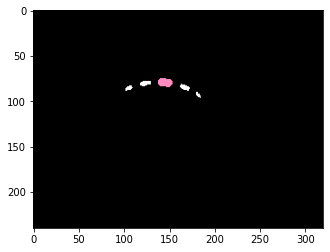

Calculated distance: 228.9425182508908
Real distance: 210.0
Calculated power: 0.7881485178110182
Real power: 0.7922087612625952


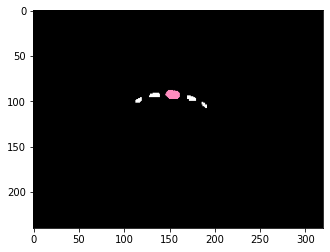

Calculated distance: 253.00153758068691
Real distance: 240.0
Calculated power: 0.790472174337337
Real power: 0.7884189062660318


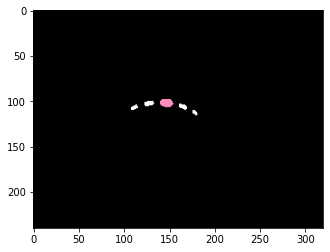

Calculated distance: 273.84842510994366
Real distance: 270.0
Calculated power: 0.7965673028302247
Real power: 0.7952340999248676


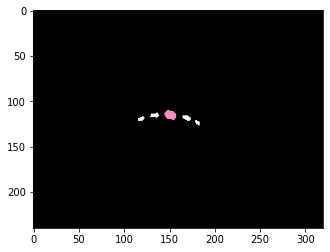

Calculated distance: 302.10380931849517
Real distance: 300.0
Calculated power: 0.8084344017749319
Real power: 0.8074473614435006


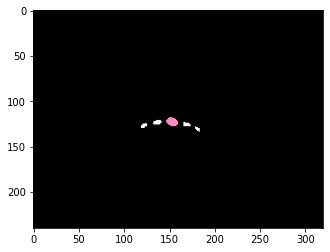

Calculated distance: 323.2675748662922
Real distance: 330.0
Calculated power: 0.8190386559644077
Real power: 0.8226260749044857


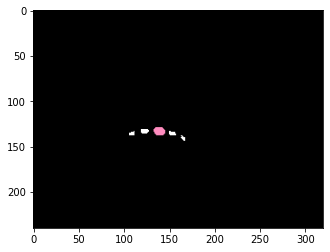

Calculated distance: 356.03155477382154
Real distance: 360.0
Calculated power: 0.8371973090728174
Real power: 0.8394966407735911


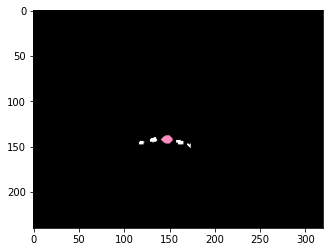

Calculated distance: 386.6164680870115
Real distance: 390.0
Calculated power: 0.8552928539011604
Real power: 0.8573384015450355


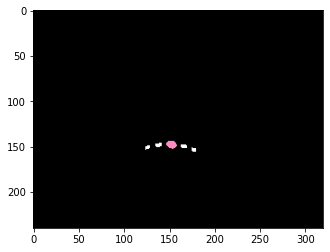

Calculated distance: 409.25679484409386
Real distance: 420.0
Calculated power: 0.8690950053149605
Real power: 0.875720373498373


In [51]:
for i in range(163,173):
  img_test = cv2.imread(str(i) + '.jpg')
  contour = getGoalContour(img_test)
  distance = getDistance(contour)
  REAL_DIST = 30 / 12 * ((i - 163) * 12 + 60)
  motor_power = getMotorPower(distance)
  REAL_MOTOR_POWER = getMotorPower(REAL_DIST)
  print('Calculated distance: ' + str(distance))
  print('Real distance: ' + str(REAL_DIST))
  print('Calculated power: ' + str(motor_power))
  print('Real power: ' + str(REAL_MOTOR_POWER))

# Best pipeline ever to step foot in a code cell

In [52]:
def runPipeline(image, llrobot):
  goal = getGoalContour(image)
  distance = getDistance(goal)
  angle = getAngle(goal)
  output = [distance, angle]
  return ([[[0, 0]], [[0, 100]], [[100, 0]], [[100, 100]]], cv2.drawContours(image.copy(), [goal], -1, (255, 0, 0), 3), output)